# Post-processing for CS 598 DEL Final Project: Randomized Smoothing vs. DICE Heuristic Attack for Community Detection
## Ian Ludden (iludden2)

In [10]:
# Import basic packages, establish global settings
from cycler import cycler 
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = '12'
plt.rcParams['axes.prop_cycle'] = cycler('color', ['b', 'g', 'r', 'c', 'm', 'y', 'k'])

In [11]:
# Summarize targets_with_smoothing.txt, targets_no_smoothing.txt
# (Size counts should match based on pick_targets.py)
size_counts = {}
with open('targets_with_smoothing.txt', 'r') as f:
    for line in f:
        size = len(line.split(' '))
        if size in size_counts:
            size_counts[size] += 1
        else:
            size_counts[size] = 1
print('With smoothing:')
print(size_counts)

size_counts = {}
with open('targets_no_smoothing.txt', 'r') as f:
    for line in f:
        size = len(line.split(' '))
        if size in size_counts:
            size_counts[size] += 1
        else:
            size_counts[size] = 1
print('No smoothing:')
print(size_counts)

With smoothing:
{4: 34, 6: 34, 8: 46}
No smoothing:
{4: 34, 6: 34, 8: 46}


In [12]:
# Summarize results with/without randomized smoothing
T = [5, 5] # No. trials
N = [10, 1] # No. iterations/samples (10 for randomized smoothing, 1 for not)
in_file = ['results_with_smoothing.out', 'results_no_smoothing.out']
out_file = ['results_summary_with_smoothing.csv', 'results_summary_no_smoothing.csv']

for q in range(2):
    with open(out_file[q], 'w') as out:
        with open(in_file[q], 'r') as f:
            for trial_index in range(1, T[q] + 1):
                f.readline() # "Trial t"
                
                out.write('Trial {0}\n'.format(trial_index))
                
                for size in size_counts:
                    avg_concealment = np.zeros((size_counts[size], size))
                    prop_detected = np.zeros(avg_concealment.shape)

                    for targets_index in range(size_counts[size]):
                        targets = f.readline().strip().split(' ') # list of targets

                        for step_index in range(len(targets)):
                            f.readline() # "Step s"
                            f.readline() # "Concealment,Detected"

                            concealment_sum = 0
                            count_detected = 0

                            for iter_index in range(N[q]):
                                line = f.readline()
                                try:
                                    [concealment, is_detected] = line.strip().split(',')
                                    concealment_sum += float(concealment)
                                    count_detected += int(is_detected)
                                except ValueError:
                                    print('Error reading line:', line)
                                    print('Current trial:', trial_index)
                                    print('Current targets:', targets)

                            avg_concealment[targets_index, step_index] = concealment_sum / N[q]
                            prop_detected[targets_index, step_index] = count_detected * 1. / N[q]

                    # Write results for size
                    out.write('Size {0}\n'.format(size))
                    out.write('Steps,Average concealment,Prop. detected\n')
                    for step_index in range(len(targets)):
                        avg_concealment_step = np.mean(avg_concealment[:, step_index])
                        prop_detected_step = np.mean(prop_detected[:, step_index])
                        out.write('{0},{1:.4f},{2:.4f}\n'.format(step_index + 1, avg_concealment_step, prop_detected_step))
                    out.write('\n')

In [13]:
# Load results summaries
T = 5
sizes = list(size_counts.keys())
avg_conceal_smoothing = np.zeros((T, len(size_counts), max(sizes)))
avg_conceal_control = np.zeros((T, len(size_counts), max(sizes)))
prop_detected_smoothing = np.zeros((T, len(size_counts), max(sizes)))
prop_detected_control = np.zeros((T, len(size_counts), max(sizes)))

for index, fname in enumerate(out_file):
    with open(fname, 'r') as f:
        for trial_index in range(T):
            f.readline() # "Trial t"

            for size_index, size in enumerate(sizes):
                f.readline() # "Size s"
                f.readline() # column headers
                for step_index in range(size):
                    line = f.readline().strip().split(',')
                    if index == 0: # with randomized smoothing
                        avg_conceal_smoothing[trial_index, size_index, step_index] = float(line[1])
                        prop_detected_smoothing[trial_index, size_index, step_index] = float(line[2])
                    else: # without randomized smoothing
                        avg_conceal_control[trial_index, size_index, step_index] = float(line[1])
                        prop_detected_control[trial_index, size_index, step_index] = float(line[2])
                        
                f.readline() # Blank line

In [14]:
# Compute averages across trials
avg_conceal_smoothing_trials = np.mean(avg_conceal_smoothing, axis=0)
avg_conceal_control_trials = np.mean(avg_conceal_control, axis=0)
prop_detected_smoothing_trials = np.mean(prop_detected_smoothing, axis=0)
prop_detected_control_trials = np.mean(prop_detected_control, axis=0)

In [17]:
# Define function for converting colored lines to black lines with unique styles
# Source: https://stackoverflow.com/questions/7358118/matplotlib-black-white-colormap-with-dashes-dots-etc
def setAxLinesBW(ax):
    """
    Take each Line2D in the axes, ax, and convert the line style to be 
    suitable for black and white viewing.
    """
    MARKERSIZE = 3

    COLORMAP = {
        'b': {'marker': None, 'dash': (None,None)},
        'g': {'marker': None, 'dash': [5,5]},
        'r': {'marker': None, 'dash': [5,3,1,3]},
        'c': {'marker': None, 'dash': [1,3]},
        'm': {'marker': None, 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': [5,3,1,2,1,10]},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }


    lines_to_adjust = ax.get_lines()
    try:
        lines_to_adjust += ax.get_legend().get_lines()
    except AttributeError:
        pass

    for line in lines_to_adjust:
        origColor = line.get_color()
        line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)

size = 4
	smoothing: [0.19366 0.20108 0.20282 0.20302]
	no smoothing: [0.17886 0.1834  0.1924  0.18224]
size = 6
	smoothing: [0.21228 0.21626 0.22108 0.22676 0.22808 0.23116]
	no smoothing: [0.1986  0.2077  0.20816 0.2106  0.2093  0.21904]
size = 8
	smoothing: [0.2174  0.22186 0.22656 0.2331  0.23756 0.24314 0.24294 0.2447 ]
	no smoothing: [0.17244 0.1806  0.19144 0.19334 0.19998 0.20722 0.21168 0.2235 ]


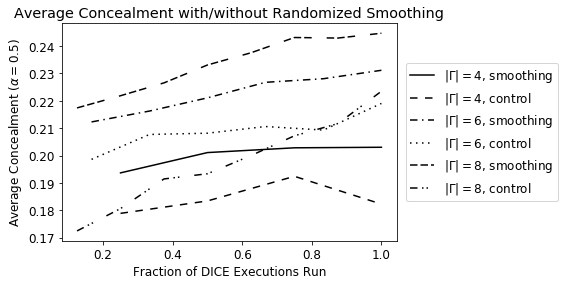

In [18]:
# Overall comparison plot: 
# Average concealment
fig, ax = plt.subplots()

for size in sizes:
    x = np.linspace(1. / size, 1, size)
    print('size =', size)
    print('\tsmoothing:', avg_conceal_smoothing_trials[sizes.index(size), :size])
    ax.plot(x, avg_conceal_smoothing_trials[sizes.index(size), :size], label='$|\Gamma|={0}$, smoothing'.format(size))
    print('\tno smoothing:', avg_conceal_control_trials[sizes.index(size), :size])
    ax.plot(x, avg_conceal_control_trials[sizes.index(size), :size], label='$|\Gamma|={0}$, control'.format(size))

plt.title("Average Concealment with/without Randomized Smoothing")
plt.xlabel('Fraction of DICE Executions Run')
plt.ylabel('Average Concealment ($\\alpha=0.5$)')
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.savefig('avg_conceal.png', bbox_inches='tight')
setAxLinesBW(ax)
plt.savefig('avg_conceal_BW.png', bbox_inches='tight')

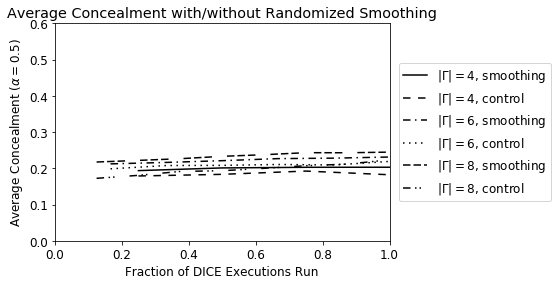

In [19]:
# Overall comparison plot: 
# Average concealment (with axes scaled to match Waniek et al.)
fig, ax = plt.subplots()
for size in sizes:
    x = np.linspace(1. / size, 1, size)
    ax.plot(x, avg_conceal_smoothing_trials[sizes.index(size), :size], label='$|\Gamma|={0}$, smoothing'.format(size))
    ax.plot(x, avg_conceal_control_trials[sizes.index(size), :size], label='$|\Gamma|={0}$, control'.format(size))

ax.set_xlim([0, 1])
ax.set_ylim([0, 0.6])
    
plt.title("Average Concealment with/without Randomized Smoothing")
plt.xlabel('Fraction of DICE Executions Run')
plt.ylabel('Average Concealment ($\\alpha=0.5$)')
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.savefig('avg_conceal_scaled.png', bbox_inches='tight')
setAxLinesBW(ax)
plt.savefig('avg_conceal_scaled_bw.png', bbox_inches='tight')

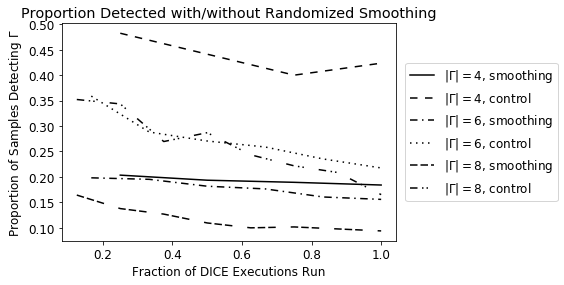

In [20]:
# Overall comparison plot:
# Proportion of runs in which target community is detected
fig, ax = plt.subplots()
for size in sizes:
    x = np.linspace(1. / size, 1, size)
    ax.plot(x, prop_detected_smoothing_trials[sizes.index(size), :size], label='$|\Gamma|={0}$, smoothing'.format(size))
    ax.plot(x, prop_detected_control_trials[sizes.index(size), :size], label='$|\Gamma|={0}$, control'.format(size))

plt.title("Proportion Detected with/without Randomized Smoothing")
plt.xlabel('Fraction of DICE Executions Run')
plt.ylabel('Proportion of Samples Detecting $\Gamma$')
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1)
plt.savefig('prop_detected.png', bbox_inches='tight')
setAxLinesBW(ax)
plt.savefig('prop_detected_BW.png', bbox_inches='tight')

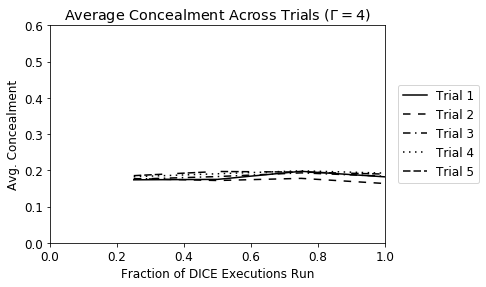

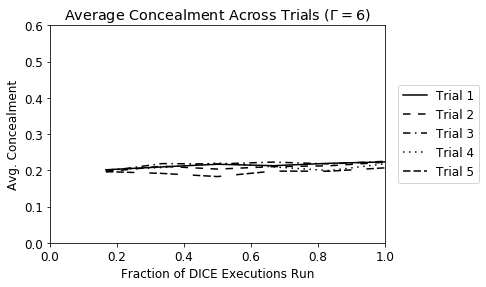

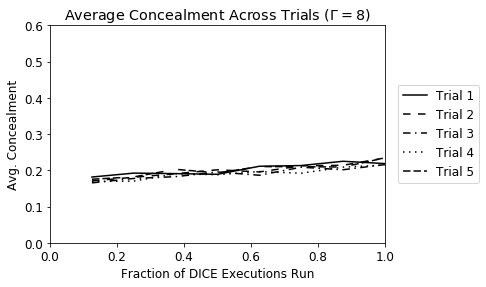

In [21]:
# Prepare plots of individual trials for each size
for size_index, size in enumerate(sizes):
    x = np.linspace(1. / size, 1, size)
    fig, ax = plt.subplots()
    for t in range(T):
        y_vals = avg_conceal_control[t,sizes.index(size),:size]
        ax.plot(x, y_vals, label='Trial {0}'.format(t + 1))
        ax.set_xlim([0, 1])
        ax.set_ylim([0,0.6])
        ax.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
        ax.set_xlabel('Fraction of DICE Executions Run')
        ax.set_ylabel('Avg. Concealment')
        ax.set_title('Average Concealment Across Trials ($\Gamma = {0}$)'.format(size))
    
    plt.savefig('trials_concealment_{0}.png'.format(size), bbox_inches='tight')
    setAxLinesBW(ax)
    plt.savefig('trials_concealment_{0}_BW.png'.format(size), bbox_inches='tight')